# Домашнее задание №7: деревья, случайный лес (14.5 баллов)
<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: основы построения решающие дерева

начнём с простого...

### Задание 1.1 (1 балл)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 - $k_2$. Посчитайте энтропию (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
import numpy as np

In [7]:
(-(8/10)*np.log(8/10) - (2/10)*np.log(2/10)).round(2)

0.5

#### (*・‿・)ノ⌒*:･ﾟ✧

### Задание 1.2 (1 балл)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности (в формулировке разности impurity пришедшей выборки и полученного разбиения) такой вершины с применением индекса Джини. Ответ округлите до двух знаков после запятой.

In [16]:
def h(p1, p2):
    return p1*(1-p1)+p2*(1-p2)

round(h(0.8, 0.2) - h(0, 1)*0.8 - h(0, 1)*0.2, 2)

0.32

#### (￣▽￣)/♫•*¨*•.¸¸♪

### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [19]:
leaf = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
sum(leaf)/len(leaf)

40.6

#### ༼ つ ◕_◕ ༽つ

## Часть 2: решающие деревья

### Задание 2.1 (2 балла)
Первым делом реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. При решении задачи регрессии испольуйте дисперсию подвыборки, при решении задачи классификации используйте критерий Джини. Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [9]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [195]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям (скачайте решённую версию ноутбука).

**Note:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла бонус 0.7 балла

In [196]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
pass

In [197]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:


    ft = pd.DataFrame({'0':feature_vector, '1':target_vector})
    ginis = []
    thresholds = np.unique(ft.iloc[:, 0])

    if feature_type == "real":
        ft.sort_values(by='0', inplace=True)
        thresholds = (thresholds[:-1] + thresholds[1:]) / 2
    for i in thresholds:
        ginis.append(Q(ft['0'], ft['1'], i, task, feature_type))

    gini_best = max(ginis)
    threshold_best = thresholds[np.argmax(ginis)]
    return (thresholds, np.array(ginis), threshold_best, gini_best)


def Q(feature_vector, target_vector, threshold, task, feature_type): 
    
    if feature_type == "real":
        left = feature_vector[feature_vector < threshold]
        lefts = target_vector[:left.shape[0]]
        rights = target_vector[left.shape[0]:]
    else:
        lefts = target_vector[feature_vector == threshold]
        rights = target_vector[feature_vector != threshold]

    if task == "regression":
        return  -(lefts.shape[0]/target_vector.shape[0]) * np.var(lefts) - (rights.shape[0]/target_vector.shape[0]) * np.var(rights)
    else:    
        return  -(lefts.shape[0]/target_vector.shape[0]) * H(lefts) - (rights.shape[0]/target_vector.shape[0]) * H(rights)

def H(target_vector):
    return 1 - np.sum(np.unique(target_vector, return_counts=True)[1] / target_vector.shape[0]**2)
    

    
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

<AxesSubplot:xlabel='threshold', ylabel='error'>

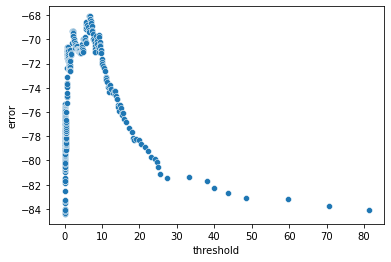

In [154]:
import seaborn as sns
d = pd.DataFrame({'error': variances, 'threshold': thresholds})
sns.scatterplot(y = 'error', x =  'threshold', data = d)

### Задание 2.2 (3 балла)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- Выбор лучшего разбиения необходимо производить по критерию Джини
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
- Ответ в листе: наиболее часто встречающийся класс в листе

In [189]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        else:
            index_now = node["feature_split"]
            variable_category = self._feature_types[index_now]
            if variable_category == "categorical":
                th_now = node["category_split"]
                if x[index_now] == th_now:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
            else:
                th_now = node["threshold"]
                if x[index_now] < th_now:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

### Задание 2.3 (1 балл)
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [190]:
data = pd.read_csv("students.csv")
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [191]:
import matplotlib.pyplot as plt

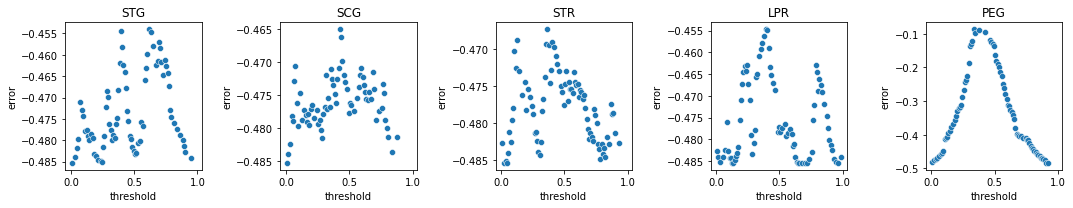

In [192]:
fig, axes = plt.subplots(1, 5, sharex=True, figsize=(15,3))
cols = data.columns[:-1]
y = data[' UNS'].to_numpy()
X = data.drop(columns = ' UNS')

for i, j in zip(cols, range(0, 5)):
    thresholds, variances, threshold_best, variance_best = find_best_split(
    X[i].to_numpy(), 
    y, 
    task="classification",
    feature_type="real"
    )
    d = pd.DataFrame({'error': variances, 'threshold': thresholds})
    sns.scatterplot(ax = axes[j], y = 'error', x =  'threshold', data = d).set_title(i)

fig.tight_layout()

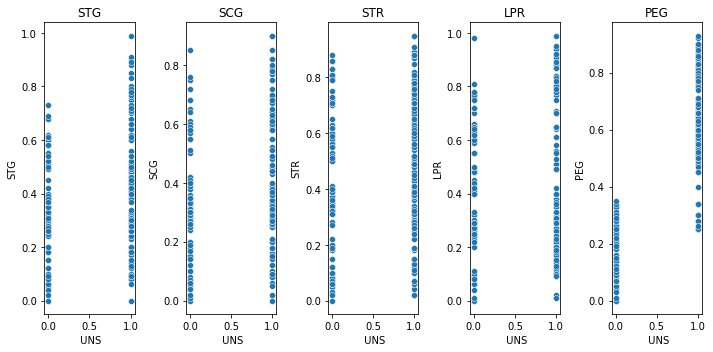

In [193]:
fig, axes = plt.subplots(1, 5, sharex=True, figsize=(10,5))
for i, j in zip(cols, range(0, 5)):
    sns.scatterplot(ax = axes[j], x = ' UNS', y =  i, data = data).set_title(i)
fig.tight_layout()

вы типа такой скэттерплот хотели?

### Задание 2.4 (1 балл)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

исходя из данных кривых, лучше всего производить деление по PEG. это согласуется с оценкой скэттерплотов, где PEG - единственно почти безошибочно визуально разделимый признак (при отсечке примерно в 0.4). думаю, оптимальная кривая - унимодальная, имеет низкое по модулю значение эррора в точке экстремума и в целом выглядит как парабола с опущенными вниз концами.
если деление невозможно (как пример, STR), сложно отследить общие тенденции графика, даже в самой высокой точке ошибка велика по модулю и точки собираются в кластеры, вместо того, чтоб кое-как апроксимироваться до кривой

### Задание 2.5 (1 балл)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [171]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


data = pd.read_csv("agaricus-lepiota.data")
data = data.apply(LabelEncoder().fit_transform)

X = data.drop(columns = ['p'])
y = data['p']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 17)

In [172]:
model = DecisionTree(feature_types= ['categorical'] * X_train.shape[1], max_depth=10, min_samples_split=1, 
                     min_samples_leaf=1)
model.fit(X_train.to_numpy(), y_train.to_numpy())
print(accuracy_score(y_test.to_numpy(), model.predict(X_test.to_numpy())))

1.0


In [173]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.to_numpy(), model.predict(X_test.to_numpy())))
#это просто пофлексить

[[2147    0]
 [   0 1915]]


## Часть 3: бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [22]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [23]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

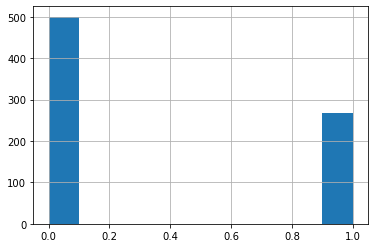

In [24]:
data['Outcome'].hist()
plt.show()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

In [25]:
X = data.drop(columns = 'Outcome')
y = data['Outcome']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 17)

In [31]:
y_train.shape[0]/y.shape[0]

0.69921875

### Задание 3.1 (1 балл)

Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [32]:
model = BaggingClassifier(n_estimators = 50)
model.fit(X_train, y_train)

BaggingClassifier(n_estimators=50)

In [37]:
y_predicted = model.predict(X_test)
print('accuracy:', accuracy_score(y_predicted, y_test))
print('precision:', precision_score(y_predicted, y_test))
print('recall:', recall_score(y_predicted, y_test))
print('roc-auc:', roc_auc_score(y_predicted, y_test))

accuracy: 0.7878787878787878
precision: 0.7037037037037037
recall: 0.6951219512195121
roc-auc: 0.7670240628580782


### Задание 3.2 (1 балл)

Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

In [39]:
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(X_train, y_train)
y_predicted = rf.predict(X_test)
print('accuracy:', accuracy_score(y_predicted, y_test))
print('precision:', precision_score(y_predicted, y_test))
print('recall:', recall_score(y_predicted, y_test))
print('roc-auc:', roc_auc_score(y_predicted, y_test))

accuracy: 0.7445887445887446
precision: 0.5925925925925926
recall: 0.6486486486486487
roc-auc: 0.7192287829230505


по всем показателям лучше оказалась модель bagging classifier

### Задание 3.3 (1 балл)

Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров (можете сделать обычный перебор с обучением/тестированием в цикле):
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

In [45]:
from sklearn.model_selection import GridSearchCV

In [92]:
parameters = {'n_estimators': np.linspace(10, 1500, 20).astype(int), 'min_samples_leaf':[i for i in range(1, 11)]}

In [93]:
forest = RandomForestClassifier()
clf = GridSearchCV(forest, parameters, scoring = 'roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': array([  10,   88,  166,  245,  323,  402,  480,  558,  637,  715,  794,
        872,  951, 1029, 1107, 1186, 1264, 1343, 1421, 1500])},
             scoring='roc_auc')

In [94]:
table = pd.DataFrame(clf.cv_results_['params'])
table['mean test score']  = clf.cv_results_['mean_test_score']
table = table.pivot("min_samples_leaf", "n_estimators", "mean test score")

In [95]:
import seaborn as sns

<AxesSubplot:xlabel='n_estimators', ylabel='min_samples_leaf'>

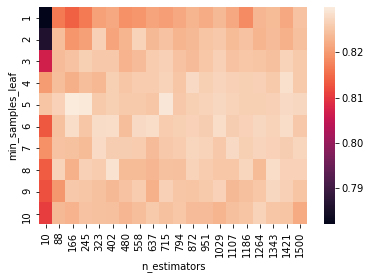

In [96]:
sns.heatmap(data = table)

тут видно, что на 10 деревьях классификация работает плохо, но не видно насколько хорошо работает все остальное. в целом, классификатор показывает средние резульатты от 0.78(?) до 0.83, что небольшая разница

<AxesSubplot:xlabel='n_estimators', ylabel='min_samples_leaf'>

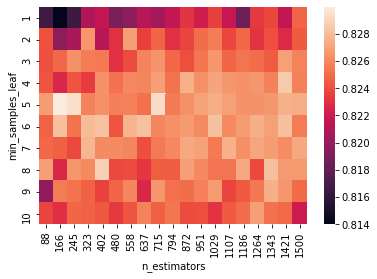

In [106]:
sns.heatmap(data = table.drop(columns = 10))

видно, что лучшее минимальное кол-во значений в листьях -- от 5 до 7, а общую тенденцию в выборе количества деревьев отследить сложно. лучшие параметры:

In [107]:
clf.best_params_

{'min_samples_leaf': 5, 'n_estimators': 166}

### Задание 3.4 (1 балл)

Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [97]:
min_leaf = clf.best_params_['min_samples_leaf']
n_est = clf.best_params_['n_estimators']

In [98]:
model = RandomForestClassifier(n_estimators = n_est, min_samples_leaf = min_leaf)

In [99]:
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=166)

<AxesSubplot:>

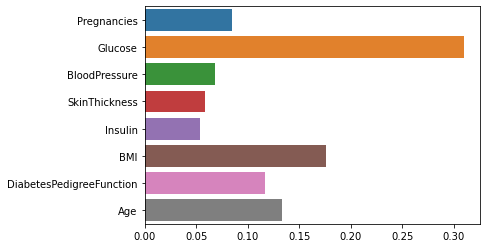

In [100]:
sns.barplot(y = X_train.columns, x = model.feature_importances_)

самым важным признаком оказался уровень глюкозы в крови пациента